# PreTrain

In [1]:
from model.sswae_dev3 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 8

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.397
[2] loss: 0.318
[3] loss: 0.140
[4] loss: 0.084
[5] loss: 0.053
[6] loss: 0.036
[7] loss: 0.025
[8] loss: 0.018
[9] loss: 0.015
[10] loss: 0.014
[11] loss: 0.009
[12] loss: 0.008
[13] loss: 0.007
[14] loss: 0.007
[15] loss: 0.006
[16] loss: 0.006
[17] loss: 0.003
[18] loss: 0.007
[19] loss: 0.003
[20] loss: 0.004
[21] loss: 0.005
[22] loss: 0.002
[23] loss: 0.001
[24] loss: 0.005
[25] loss: 0.004


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 8])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

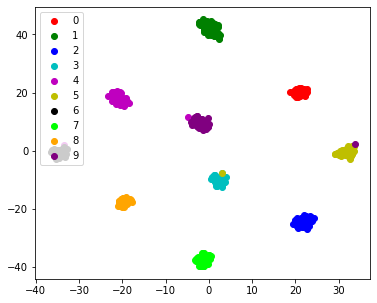

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

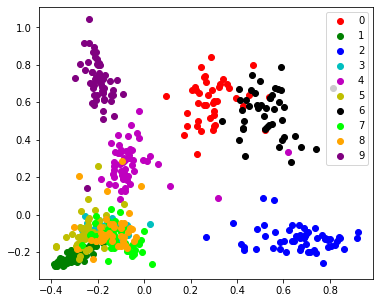

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
# labeled_class = [0,1,2,3,4,5,6,7,8,9]
# train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
# train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
# ys = np.zeros((10, y_dim))
# cs = np.zeros(10)

# for data, condition in train_generator:
#     n = len(data)
#     x = data.to(device)
#     y = condition.to(device)
#     z = embed_condition(embed_data(x))
    
#     labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
#     idxs = labs[idxs].view(n,1).expand(-1, y_dim)
#     cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
#     ys += cc.detach().to('cpu').numpy()
#     cs += counts[labs].detach().to('cpu').numpy()

In [12]:
# w = torch.Tensor(ys.transpose()/cs)
# w

In [13]:
# f1 = nn.Linear(10, y_dim, bias = False)
# f1.weight.data = w
# torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')
f1 = nn.Sequential(embed_data, embed_condition)
torch.save(f1.state_dict(), f'./result/f1_dev3_{y_dim}.pt')

# Train

In [14]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev3_3.cfg')

['./config/sswae_dev3_3.cfg']

In [15]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_dev3_{y_dim}.pt'))
mm.train()

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 8
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1539] [01/80]  loss: 2.300319e-01  D: 6.873610e-01  D2: 0.000000e+00  D3: 3.761199e-03
test loss: 1.721357e-01  D: 6.980040e-01  D2: 0.000000e+00  D3: 7.539235e-03


[default |INFO|model.py:1539] [02/80]  loss: 1.656606e-01  D: 6.941644e-01  D2: 0.000000e+00  D3: 8.424656e-03
test loss: 1.604097e-01  D: 6.785719e-01  D2: 0.000000e+00  D3: 5.603415e-03


[default |INFO|model.py:1539] [03/80]  loss: 1.525380e-01  D: 6.916684e-01  D2: 0.000000e+00  D3: 8.770388e-03
test loss: 1.485706e-01  D: 6.888381e-01  D2: 0.000000e+00  D3: 8.784927e-03


[default |INFO|model.py:1539] [04/80]  loss: 1.417365e-01  D: 6.932715e-01  D2: 0.000000e+00  D3: 9.209914e-03
test loss: 1.299279e-01  D: 6.932546e-01  D2: 0.000000e+00  D3: 1.101874e-02


[default |INFO|model.py:1539] [05/80]  loss: 1.184657e-01  D: 6.938119e-01  D2: 0.000000e+00  D3: 8.252325e-03
test loss: 1.087719e-01  D: 6.957598e-01  D2: 0.000000e+00  D3: 8.165549e-03


[default |INFO|model.py:1539] [06/80]  loss: 1.104977e-01  D: 6.935068e-01  D2: 0.000000e+00  D3: 8.329279e-03
test loss: 1.045630e-01  D: 6.911313e-01  D2: 0.000000e+00  D3: 7.443428e-03


[default |INFO|model.py:1539] [07/80]  loss: 1.014269e-01  D: 6.940563e-01  D2: 0.000000e+00  D3: 7.696789e-03
test loss: 9.745897e-02  D: 7.023515e-01  D2: 0.000000e+00  D3: 1.050534e-02


[default |INFO|model.py:1539] [08/80]  loss: 1.029505e-01  D: 6.944207e-01  D2: 0.000000e+00  D3: 1.138997e-02
test loss: 1.127057e-01  D: 7.037773e-01  D2: 0.000000e+00  D3: 1.454923e-02


[default |INFO|model.py:1539] [09/80]  loss: 1.021882e-01  D: 6.949768e-01  D2: 0.000000e+00  D3: 1.273499e-02
test loss: 9.894402e-02  D: 6.923919e-01  D2: 0.000000e+00  D3: 1.445718e-02


[default |INFO|model.py:1539] [10/80]  loss: 1.129123e-01  D: 7.028670e-01  D2: 0.000000e+00  D3: 1.740875e-02
test loss: 1.295043e-01  D: 7.547678e-01  D2: 0.000000e+00  D3: 2.040375e-02


[default |INFO|model.py:1539] [11/80]  loss: 1.161760e-01  D: 6.947688e-01  D2: 0.000000e+00  D3: 1.639226e-02
test loss: 9.881162e-02  D: 7.078910e-01  D2: 0.000000e+00  D3: 1.960825e-02


[default |INFO|model.py:1539] [12/80]  loss: 9.732258e-02  D: 6.931592e-01  D2: 0.000000e+00  D3: 1.893314e-02
test loss: 9.197952e-02  D: 7.145448e-01  D2: 0.000000e+00  D3: 1.834918e-02


[default |INFO|model.py:1539] [13/80]  loss: 9.055821e-02  D: 6.929358e-01  D2: 0.000000e+00  D3: 1.903232e-02
test loss: 8.934571e-02  D: 6.863632e-01  D2: 0.000000e+00  D3: 1.954689e-02


[default |INFO|model.py:1539] [14/80]  loss: 8.742436e-02  D: 6.930545e-01  D2: 0.000000e+00  D3: 1.876374e-02
test loss: 8.435175e-02  D: 6.895488e-01  D2: 0.000000e+00  D3: 1.915784e-02


[default |INFO|model.py:1539] [15/80]  loss: 8.342401e-02  D: 6.933869e-01  D2: 0.000000e+00  D3: 1.850340e-02
test loss: 8.488207e-02  D: 6.944097e-01  D2: 0.000000e+00  D3: 2.026116e-02


[default |INFO|model.py:1539] [16/80]  loss: 8.266566e-02  D: 6.929484e-01  D2: 0.000000e+00  D3: 1.866747e-02
test loss: 8.022761e-02  D: 6.967676e-01  D2: 0.000000e+00  D3: 1.906137e-02


[default |INFO|model.py:1539] [17/80]  loss: 8.457213e-02  D: 6.925376e-01  D2: 0.000000e+00  D3: 1.791482e-02
test loss: 8.183685e-02  D: 6.918124e-01  D2: 0.000000e+00  D3: 1.481703e-02


[default |INFO|model.py:1539] [18/80]  loss: 8.149920e-02  D: 6.951114e-01  D2: 0.000000e+00  D3: 1.782033e-02
test loss: 8.037124e-02  D: 6.891223e-01  D2: 0.000000e+00  D3: 1.987445e-02


[default |INFO|model.py:1539] [19/80]  loss: 7.992239e-02  D: 6.939900e-01  D2: 0.000000e+00  D3: 1.804347e-02
test loss: 7.810242e-02  D: 6.945368e-01  D2: 0.000000e+00  D3: 1.960270e-02


[default |INFO|model.py:1539] [20/80]  loss: 7.852299e-02  D: 6.921319e-01  D2: 0.000000e+00  D3: 1.832672e-02
test loss: 7.910280e-02  D: 6.881005e-01  D2: 0.000000e+00  D3: 1.988584e-02


[default |INFO|model.py:1539] [21/80]  loss: 8.144583e-02  D: 6.939921e-01  D2: 0.000000e+00  D3: 1.721271e-02
test loss: 7.803228e-02  D: 6.806419e-01  D2: 0.000000e+00  D3: 1.317607e-02


[default |INFO|model.py:1539] [22/80]  loss: 8.118435e-02  D: 6.924159e-01  D2: 0.000000e+00  D3: 1.697511e-02
test loss: 8.322701e-02  D: 7.028267e-01  D2: 0.000000e+00  D3: 1.935461e-02


[default |INFO|model.py:1539] [23/80]  loss: 8.017245e-02  D: 6.936890e-01  D2: 0.000000e+00  D3: 1.745278e-02
test loss: 8.111636e-02  D: 6.836982e-01  D2: 0.000000e+00  D3: 1.147842e-02


[default |INFO|model.py:1539] [24/80]  loss: 7.925305e-02  D: 6.942806e-01  D2: 0.000000e+00  D3: 1.753593e-02
test loss: 7.705050e-02  D: 6.824975e-01  D2: 0.000000e+00  D3: 2.060191e-02


[default |INFO|model.py:1539] [25/80]  loss: 7.832084e-02  D: 6.932737e-01  D2: 0.000000e+00  D3: 1.738656e-02
test loss: 7.800597e-02  D: 7.046912e-01  D2: 0.000000e+00  D3: 1.790107e-02


[default |INFO|model.py:1539] [26/80]  loss: 7.751587e-02  D: 6.942802e-01  D2: 0.000000e+00  D3: 1.729702e-02
test loss: 7.589976e-02  D: 6.792251e-01  D2: 0.000000e+00  D3: 1.816344e-02


[default |INFO|model.py:1539] [27/80]  loss: 7.814331e-02  D: 6.933003e-01  D2: 0.000000e+00  D3: 1.659123e-02
test loss: 8.373637e-02  D: 6.733914e-01  D2: 0.000000e+00  D3: 1.417459e-02


[default |INFO|model.py:1539] [28/80]  loss: 7.766722e-02  D: 6.938893e-01  D2: 0.000000e+00  D3: 1.714512e-02
test loss: 7.865624e-02  D: 6.837089e-01  D2: 0.000000e+00  D3: 1.095932e-02


[default |INFO|model.py:1539] [29/80]  loss: 7.609925e-02  D: 6.938403e-01  D2: 0.000000e+00  D3: 1.773483e-02
test loss: 7.399137e-02  D: 7.039589e-01  D2: 0.000000e+00  D3: 1.809576e-02


[default |INFO|model.py:1539] [30/80]  loss: 7.501781e-02  D: 6.952372e-01  D2: 0.000000e+00  D3: 1.745457e-02
test loss: 7.398100e-02  D: 6.888503e-01  D2: 0.000000e+00  D3: 1.725493e-02


[default |INFO|model.py:1539] [31/80]  loss: 7.426490e-02  D: 6.945544e-01  D2: 0.000000e+00  D3: 1.785661e-02
test loss: 8.909229e-02  D: 6.879587e-01  D2: 0.000000e+00  D3: 1.674567e-02


[default |INFO|model.py:1539] [32/80]  loss: 7.393138e-02  D: 6.918188e-01  D2: 0.000000e+00  D3: 1.719126e-02
test loss: 7.236137e-02  D: 6.848211e-01  D2: 0.000000e+00  D3: 1.851799e-02


[default |INFO|model.py:1539] [33/80]  loss: 7.190769e-02  D: 6.928567e-01  D2: 0.000000e+00  D3: 1.772312e-02
test loss: 7.122132e-02  D: 7.123081e-01  D2: 0.000000e+00  D3: 1.874335e-02


[default |INFO|model.py:1539] [34/80]  loss: 6.926197e-02  D: 6.960285e-01  D2: 0.000000e+00  D3: 1.789951e-02
test loss: 6.906952e-02  D: 6.822353e-01  D2: 0.000000e+00  D3: 1.673858e-02


[default |INFO|model.py:1539] [35/80]  loss: 6.955693e-02  D: 6.925249e-01  D2: 0.000000e+00  D3: 1.785033e-02
test loss: 7.132846e-02  D: 6.866274e-01  D2: 0.000000e+00  D3: 1.593182e-02


[default |INFO|model.py:1539] [36/80]  loss: 7.185558e-02  D: 6.937166e-01  D2: 0.000000e+00  D3: 1.727914e-02
test loss: 7.116989e-02  D: 6.997993e-01  D2: 0.000000e+00  D3: 1.812960e-02


[default |INFO|model.py:1539] [37/80]  loss: 6.888594e-02  D: 6.937013e-01  D2: 0.000000e+00  D3: 1.733864e-02
test loss: 7.123824e-02  D: 6.795872e-01  D2: 0.000000e+00  D3: 1.485646e-02


[default |INFO|model.py:1539] [38/80]  loss: 6.976935e-02  D: 6.937063e-01  D2: 0.000000e+00  D3: 1.719393e-02
test loss: 7.095587e-02  D: 6.988281e-01  D2: 0.000000e+00  D3: 2.006233e-02


[default |INFO|model.py:1539] [39/80]  loss: 7.150461e-02  D: 6.936583e-01  D2: 0.000000e+00  D3: 1.685330e-02
test loss: 7.502081e-02  D: 6.733835e-01  D2: 0.000000e+00  D3: 1.350242e-02


[default |INFO|model.py:1539] [40/80]  loss: 7.141080e-02  D: 6.943842e-01  D2: 0.000000e+00  D3: 1.713848e-02
test loss: 6.973514e-02  D: 6.890072e-01  D2: 0.000000e+00  D3: 1.728517e-02


[default |INFO|model.py:1539] [41/80]  loss: 6.988876e-02  D: 6.930574e-01  D2: 0.000000e+00  D3: 1.704265e-02
test loss: 7.187632e-02  D: 6.680786e-01  D2: 0.000000e+00  D3: 1.827763e-02


[default |INFO|model.py:1539] [42/80]  loss: 6.804648e-02  D: 6.954792e-01  D2: 0.000000e+00  D3: 1.754534e-02
test loss: 6.893382e-02  D: 6.724004e-01  D2: 0.000000e+00  D3: 1.695375e-02


[default |INFO|model.py:1539] [43/80]  loss: 6.678771e-02  D: 6.931859e-01  D2: 0.000000e+00  D3: 1.746589e-02
test loss: 6.903495e-02  D: 6.913647e-01  D2: 0.000000e+00  D3: 1.845121e-02


[default |INFO|model.py:1539] [44/80]  loss: 6.758739e-02  D: 6.935769e-01  D2: 0.000000e+00  D3: 1.719091e-02
test loss: 7.125215e-02  D: 6.838871e-01  D2: 0.000000e+00  D3: 1.658816e-02


[default |INFO|model.py:1539] [45/80]  loss: 7.001828e-02  D: 6.946897e-01  D2: 0.000000e+00  D3: 1.717252e-02
test loss: 6.705712e-02  D: 6.849153e-01  D2: 0.000000e+00  D3: 1.712153e-02


[default |INFO|model.py:1539] [46/80]  loss: 6.598841e-02  D: 6.941927e-01  D2: 0.000000e+00  D3: 1.749699e-02
test loss: 7.081560e-02  D: 6.796923e-01  D2: 0.000000e+00  D3: 1.667271e-02


[default |INFO|model.py:1539] [47/80]  loss: 6.686935e-02  D: 6.930583e-01  D2: 0.000000e+00  D3: 1.715874e-02
test loss: 6.893611e-02  D: 6.726361e-01  D2: 0.000000e+00  D3: 1.572105e-02


[default |INFO|model.py:1539] [48/80]  loss: 6.614728e-02  D: 6.928016e-01  D2: 0.000000e+00  D3: 1.725116e-02
test loss: 6.682937e-02  D: 6.923560e-01  D2: 0.000000e+00  D3: 1.736342e-02


[default |INFO|model.py:1539] [49/80]  loss: 6.687780e-02  D: 6.940238e-01  D2: 0.000000e+00  D3: 1.712036e-02
test loss: 6.845349e-02  D: 6.877751e-01  D2: 0.000000e+00  D3: 1.755853e-02


[default |INFO|model.py:1539] [50/80]  loss: 6.539769e-02  D: 6.932931e-01  D2: 0.000000e+00  D3: 1.713492e-02
test loss: 7.066357e-02  D: 6.977372e-01  D2: 0.000000e+00  D3: 1.780985e-02


[default |INFO|model.py:1539] [51/80]  loss: 6.493045e-02  D: 6.930354e-01  D2: 0.000000e+00  D3: 1.739838e-02
test loss: 6.674794e-02  D: 6.959382e-01  D2: 0.000000e+00  D3: 1.850117e-02


[default |INFO|model.py:1539] [52/80]  loss: 6.519350e-02  D: 6.936137e-01  D2: 0.000000e+00  D3: 1.707653e-02
test loss: 7.000920e-02  D: 6.966604e-01  D2: 0.000000e+00  D3: 1.790653e-02


[default |INFO|model.py:1539] [53/80]  loss: 6.666108e-02  D: 6.947210e-01  D2: 0.000000e+00  D3: 1.702635e-02
test loss: 6.663834e-02  D: 7.058472e-01  D2: 0.000000e+00  D3: 1.710583e-02


[default |INFO|model.py:1539] [54/80]  loss: 6.610357e-02  D: 6.940841e-01  D2: 0.000000e+00  D3: 1.699218e-02
test loss: 6.726280e-02  D: 6.898171e-01  D2: 0.000000e+00  D3: 1.626741e-02


[default |INFO|model.py:1539] [55/80]  loss: 6.574942e-02  D: 6.937550e-01  D2: 0.000000e+00  D3: 1.704679e-02
test loss: 6.720045e-02  D: 6.892926e-01  D2: 0.000000e+00  D3: 1.719218e-02


[default |INFO|model.py:1539] [56/80]  loss: 6.546260e-02  D: 6.938220e-01  D2: 0.000000e+00  D3: 1.700340e-02
test loss: 6.776059e-02  D: 6.917615e-01  D2: 0.000000e+00  D3: 1.669791e-02


[default |INFO|model.py:1539] [57/80]  loss: 6.541195e-02  D: 6.933570e-01  D2: 0.000000e+00  D3: 1.690965e-02
test loss: 6.813682e-02  D: 6.906167e-01  D2: 0.000000e+00  D3: 1.784801e-02


[default |INFO|model.py:1539] [58/80]  loss: 6.552604e-02  D: 6.946560e-01  D2: 0.000000e+00  D3: 1.690450e-02
test loss: 6.813862e-02  D: 6.853103e-01  D2: 0.000000e+00  D3: 1.559375e-02


[default |INFO|model.py:1539] [59/80]  loss: 6.507358e-02  D: 6.929771e-01  D2: 0.000000e+00  D3: 1.688780e-02
test loss: 6.591047e-02  D: 6.862525e-01  D2: 0.000000e+00  D3: 1.723404e-02


[default |INFO|model.py:1539] [60/80]  loss: 6.454239e-02  D: 6.930289e-01  D2: 0.000000e+00  D3: 1.697954e-02
test loss: 6.508200e-02  D: 6.872231e-01  D2: 0.000000e+00  D3: 1.807348e-02


[default |INFO|model.py:1539] [61/80]  loss: 6.495073e-02  D: 6.940032e-01  D2: 0.000000e+00  D3: 1.683992e-02
test loss: 6.686026e-02  D: 6.845073e-01  D2: 0.000000e+00  D3: 1.626263e-02


[default |INFO|model.py:1539] [62/80]  loss: 6.488018e-02  D: 6.927054e-01  D2: 0.000000e+00  D3: 1.692896e-02
test loss: 6.639407e-02  D: 7.007394e-01  D2: 0.000000e+00  D3: 1.797070e-02


[default |INFO|model.py:1539] [63/80]  loss: 6.363436e-02  D: 6.935212e-01  D2: 0.000000e+00  D3: 1.701966e-02
test loss: 6.781807e-02  D: 6.944297e-01  D2: 0.000000e+00  D3: 1.568529e-02


[default |INFO|model.py:1539] [64/80]  loss: 6.414194e-02  D: 6.950000e-01  D2: 0.000000e+00  D3: 1.694135e-02
test loss: 7.975722e-02  D: 6.863671e-01  D2: 0.000000e+00  D3: 1.603085e-02


[default |INFO|model.py:1539] [65/80]  loss: 6.326551e-02  D: 6.936861e-01  D2: 0.000000e+00  D3: 1.699067e-02
test loss: 6.466666e-02  D: 6.931805e-01  D2: 0.000000e+00  D3: 1.720024e-02


[default |INFO|model.py:1539] [66/80]  loss: 6.294011e-02  D: 6.932452e-01  D2: 0.000000e+00  D3: 1.685767e-02
test loss: 6.746464e-02  D: 6.818576e-01  D2: 0.000000e+00  D3: 1.752783e-02


[default |INFO|model.py:1539] [67/80]  loss: 6.354675e-02  D: 6.932347e-01  D2: 0.000000e+00  D3: 1.668822e-02
test loss: 6.635061e-02  D: 6.932299e-01  D2: 0.000000e+00  D3: 1.641978e-02


[default |INFO|model.py:1539] [68/80]  loss: 6.292357e-02  D: 6.941370e-01  D2: 0.000000e+00  D3: 1.701787e-02
test loss: 6.627355e-02  D: 7.010389e-01  D2: 0.000000e+00  D3: 1.688601e-02


[default |INFO|model.py:1539] [69/80]  loss: 6.305840e-02  D: 6.937838e-01  D2: 0.000000e+00  D3: 1.677343e-02
test loss: 6.617551e-02  D: 6.983658e-01  D2: 0.000000e+00  D3: 1.622171e-02


[default |INFO|model.py:1539] [70/80]  loss: 6.233615e-02  D: 6.939670e-01  D2: 0.000000e+00  D3: 1.693528e-02
test loss: 6.513376e-02  D: 7.072999e-01  D2: 0.000000e+00  D3: 1.657522e-02


[default |INFO|model.py:1539] [71/80]  loss: 6.220921e-02  D: 6.930967e-01  D2: 0.000000e+00  D3: 1.685317e-02
test loss: 6.506983e-02  D: 6.901140e-01  D2: 0.000000e+00  D3: 1.694356e-02


[default |INFO|model.py:1539] [72/80]  loss: 6.264641e-02  D: 6.926984e-01  D2: 0.000000e+00  D3: 1.685988e-02
test loss: 6.653186e-02  D: 7.088084e-01  D2: 0.000000e+00  D3: 1.946393e-02


[default |INFO|model.py:1539] [73/80]  loss: 6.312864e-02  D: 6.941644e-01  D2: 0.000000e+00  D3: 1.664903e-02
test loss: 6.639314e-02  D: 7.065827e-01  D2: 0.000000e+00  D3: 1.719319e-02


[default |INFO|model.py:1539] [74/80]  loss: 6.205764e-02  D: 6.937806e-01  D2: 0.000000e+00  D3: 1.676573e-02
test loss: 6.459935e-02  D: 7.003781e-01  D2: 0.000000e+00  D3: 1.677183e-02


[default |INFO|model.py:1539] [75/80]  loss: 6.231184e-02  D: 6.935637e-01  D2: 0.000000e+00  D3: 1.662972e-02
test loss: 6.449642e-02  D: 6.924468e-01  D2: 0.000000e+00  D3: 1.747417e-02


[default |INFO|model.py:1539] [76/80]  loss: 6.182673e-02  D: 6.927213e-01  D2: 0.000000e+00  D3: 1.673056e-02
test loss: 6.655549e-02  D: 6.873074e-01  D2: 0.000000e+00  D3: 1.750894e-02


[default |INFO|model.py:1539] [77/80]  loss: 6.178113e-02  D: 6.936592e-01  D2: 0.000000e+00  D3: 1.662555e-02
test loss: 6.528796e-02  D: 6.966138e-01  D2: 0.000000e+00  D3: 1.631603e-02


[default |INFO|model.py:1539] [78/80]  loss: 6.317685e-02  D: 6.927975e-01  D2: 0.000000e+00  D3: 1.640598e-02
test loss: 6.612325e-02  D: 6.930157e-01  D2: 0.000000e+00  D3: 1.735907e-02


[default |INFO|model.py:1539] [79/80]  loss: 6.244544e-02  D: 6.949738e-01  D2: 0.000000e+00  D3: 1.682757e-02
test loss: 6.582212e-02  D: 7.088112e-01  D2: 0.000000e+00  D3: 1.524075e-02


[default |INFO|model.py:1539] [80/80]  loss: 6.125109e-02  D: 6.946943e-01  D2: 0.000000e+00  D3: 1.659233e-02
test loss: 6.689473e-02  D: 7.027390e-01  D2: 0.000000e+00  D3: 1.663734e-02


[default |INFO|model.py:1609] Training Finished!
[default |INFO|model.py:1610] Elapsed time: 4288.448s


# Test

In [16]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [17]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [18]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

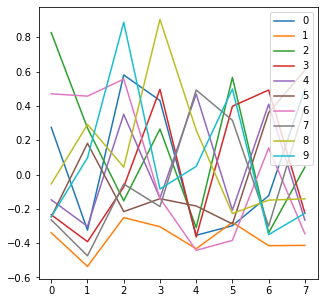

In [19]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

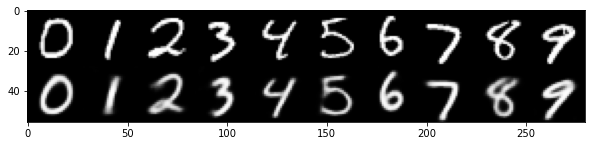

In [20]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [21]:
exn = 5

In [22]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

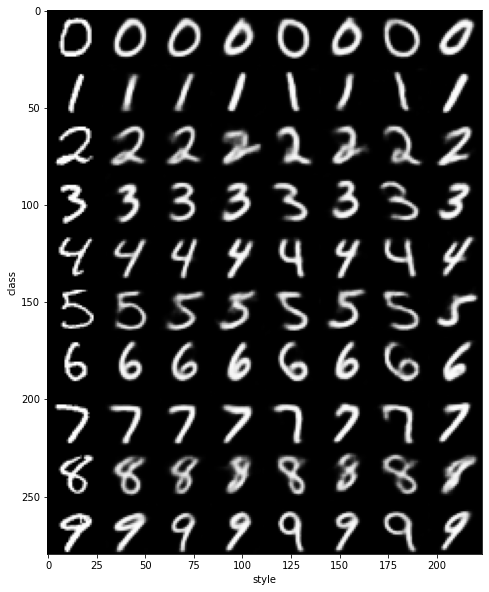

In [23]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [24]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

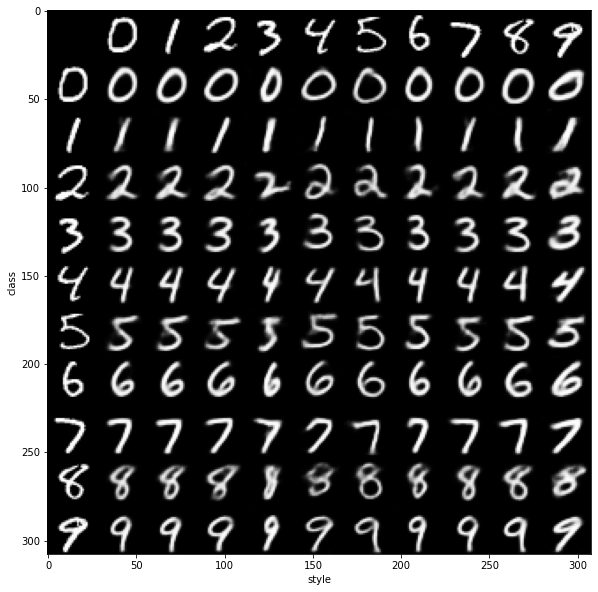

In [25]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()